In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize


files=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
#files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
  
prices=list()
sentiment=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDatasetUpdated/Sentiment/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    #sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDataset/SentimentFul/'+file+'.csv')
    #price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price['Unnamed: 0'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['Unnamed: 0']]
    price['Unnamed: 0'] = [row-timedelta(hours=8) for row in price['Unnamed: 0']]
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    print(file)
   
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,sentimentVector.rolling(5).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(10).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(15).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(20).mean()),axis=1)
    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL
AMZN
PEP
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
BKNG
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d,le):
    model = Sequential()  
    model.add(Dense(n, input_dim=40,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    opt=optimizers.Adam(lr=le)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
           


Working on... AAPL
15.571701720841297
0.005338458253266777
F1,score 0.792573623559539
G-score: 0.6054782883279682
Accuracy 0.7132743362831858
Window: 140
[[187 319]
 [  5 619]]
Vol pos 3.4143031307962906
Vol neg 2.576574378642768
Real Percentage of gain: 203.81257870923642
Percentage of gain: 1.6965648006562417
Total gain: 1917.1182247415531
000000000000000000000000000000000000000000000000
Percentile:  0
[[155 223]
 [  5 370]]
0.6972111553784861
Percentile:  1
[[32 36]
 [ 0 84]]
0.7631578947368421
Percentile:  2
[[ 0 60]
 [ 0 79]]
0.5683453237410072
Percentile:  3
[[49]]
1.0
Percentile:  4
[[35]]
1.0
000000000000000000000000000000000000000000000000
Working on... AMZN
11.150617492631287
0.0007590184265374819
F1,score 0.8756218905472637
G-score: 0.08921369332928565
Accuracy 0.7791519434628975
Window: 140
[[  2 249]
 [  1 880]]
Vol pos 2.541087411281231
Vol neg 1.734446448999361
Real Percentage of gain: 248.8554948607676
Percentage of gain: 1.5968440675796867
Total gain: 1807.627484500205

9.949148290880911
0.0
F1,score 0.5641025641025641
G-score: 0.5341021490938086
Accuracy 0.5181576616474757
Window: 140
[[233 155]
 [389 352]]
Vol pos 2.648652033366872
Vol neg 2.5547290481856795
Real Percentage of gain: -14.43421343127332
Percentage of gain: 0.14144272569230346
Total gain: 159.6888373066106
000000000000000000000000000000000000000000000000
Percentile:  0
[[194  83]
 [173 111]]
0.5436720142602496
Percentile:  1
[[ 31  32]
 [147 114]]
0.44753086419753085
Percentile:  2
[[ 3 22]
 [62 71]]
0.46835443037974683
Percentile:  3
[[ 5 18]
 [ 3 40]]
0.6818181818181818
Percentile:  4
[[ 0  0]
 [ 3 15]]
0.8333333333333334
000000000000000000000000000000000000000000000000
Working on... AMGN
6.235840507476206
0.0
F1,score 0.8039538714991763
G-score: 0.3112162298443888
Accuracy 0.6821015138023152
Window: 140
[[ 34 286]
 [ 71 732]]
Vol pos 1.9646605718337153
Vol neg 1.8595508614767033
Real Percentage of gain: 144.132095117292
Percentage of gain: 0.7489495462844549
Total gain: 841.07034047

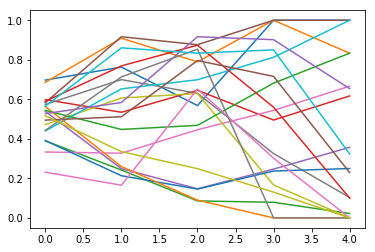

Ecco la matrice generale:
[[2922. 4554.]
 [5508. 8397.]]
Ecco le matrici per percentile
Percentile : 0
[[1680. 2602.]
 [2014. 3275.]]
Percentile : 1
[[ 609. 1003.]
 [1720. 2938.]]
Percentile : 2
[[ 449.  376.]
 [1133. 1345.]]
Percentile : 3
[[237. 404.]
 [528. 602.]]
Percentile : 4
[[146. 365.]
 [304. 217.]]


In [4]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]
totalconfusion=np.zeros((2,2))
confusionlist=[]
for con in range(0,5):
    confusionlist.append(np.zeros((2,2)))

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    
    #print(xtemp)
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    percfinal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        percentage=[]
        
        yvolatility=[]
        yprice=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open']) 
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(xtemp[i])
        
        y=np.array(y)
        x=np.array(x)
        scaler = MinMaxScaler() 
        scaler.fit(x)
        MinMaxScaler(copy=True, feature_range=(0, 1))
        x=scaler.transform(x)
        yvolatility=np.array(yvolatility)
       
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    


        
        
                        
        gnb = GaussianNB()                
        prediction=gnb.fit(x_tv, y_tv).predict(x_test)

                        
      
       
        
        
 

        acctotal.append(accuracy_score(y_test, prediction))
        confmatrix=confusion_matrix(y_test, prediction)
        totalconfusion=totalconfusion+confmatrix
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction)
        
        print('F1,score',CM)
        print('G-score:',valueacc)
        realacc=accuracy_score(y_test, prediction)
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print('Window:',t)
        print(confmatrix)
        print('Vol pos',sum(volr)/len(volr))
        print('Vol neg',sum(voln)/len(voln))
        percnegtotal.append(sum(volr)/len(volr))
        percpostotal.append(sum(voln)/len(voln))
        #build structure to plot distribution onver percentile
        chart=np.zeros(5)
        for r in range(0,len(y_test)):
            for v in range(0,5):
                if(yvolatilitytest[r]<min(yvolatility)+step+step*v and yvolatilitytest[r]>min(yvolatility)+step*v):
                    chart[v]+=1
        #plt.plot(chart)
        #plt.show()
        print('Real Percentage of gain:',(pricegain*100)/(sum(price.iloc[1:6]['open'])))
        pricegainlist.append((pricegain*100)/(sum(price.iloc[1:6]['open'])))
        print('Percentage of gain:',(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('Total gain:',len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        gainlist.append(len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        for g in range(0,len(distribution)):
            print('Percentile: ',g)
            tempscore=0
            if(len(distribution[g])>0):
                predictionp=gnb.predict(x_test[distribution[g]])
                
                tempmatrix=confusion_matrix(y_test[distribution[g]], predictionp)
                confusionlist[g]=confusionlist[g]+tempmatrix
                print(tempmatrix)
                
                tempscore=accuracy_score(y_test[distribution[g]],predictionp)
                print(tempscore)
            chartscore.append(tempscore)    
        chartlist.append(chartscore)
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))
print('Mean gain over portfolio : ', sum(gainlist)/len(gainlist))
print('Real mean gain over portfolio',sum(pricegainlist)/len(pricegainlist))
#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
print('Ecco la matrice generale:')
print(totalconfusion)
print('Ecco le matrici per percentile')
for i in range(0,len(confusionlist)):
    print('Percentile :',i)
    print(confusionlist[i])        

            

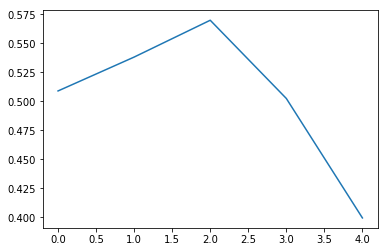

In [5]:
tot=np.zeros(5)
for st in range(0,len(chartlist)):
    tot=chartlist[st]+tot
    
tot=tot/len(chartlist)
plt.plot(tot)
plt.show()

In [6]:
l=[]
for i in range(0,5):
    l.append(np.zeros((2,2)))
l[0]=l[0]+confmatrix
print(l[0])
print('[[[]]]')
z=np.zeros((2,2))
print(confmatrix)
z=z+confmatrix
print(z)

[[  0. 355.]
 [  0. 776.]]
[[[]]]
[[  0 355]
 [  0 776]]
[[  0. 355.]
 [  0. 776.]]


In [ ]:
#print('ACCURACY on val:',maxacc)
        print('Test')
        model=buildModel(maxl,maxu)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs=20,shuffle=False, verbose=2,batch_size=100,validation_data=(x_test,y_test))
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        
        e=findMaxAccStep(history.history['val_acc'],history.history['val_loss'])
        model.fit(x_tv, y_tv, epochs=e,shuffle=False, verbose=0,batch_size=10)
        prediction=model.predict( x_test, batch_size=10, verbose=0, steps=None)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()

In [ ]:
tempacc=accstocksresults

In [ ]:
import operator
t=[0,0,0]
for i in range(0,len(tempacc)):
    t=np.add(t,tempacc[i])
print(t)
print(t/len(tempacc))

In [ ]:
Working on... AAPL
/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
Window: 2
[[249  81]
 [263 107]]
F1,score 0.38351254480286734
Accuracy: 0.5085714285714286
Window: 4
[[  0 323]
 [  0 376]]
F1,score 0.6995348837209303
Accuracy: 0.5379113018597997
Window: 6
[[243  85]
 [271 100]]
F1,score 0.35971223021582727
Accuracy: 0.4907010014306152
Window: 10
[[247  77]
 [234 140]]
F1,score 0.4737732656514382
Accuracy: 0.5544412607449857
Window: 16
[[257  67]
 [259 114]]
F1,score 0.4115523465703971
Accuracy: 0.5322812051649928
Window: 24
[[210  96]
 [253 136]]
F1,score 0.43800322061191627
Accuracy: 0.497841726618705
Window: 32
[[192 107]
 [217 178]]
F1,score 0.5235294117647058
Accuracy: 0.5331412103746398
Window: 42
[[219  76]
 [235 162]]
F1,score 0.5102362204724409
Accuracy: 0.5505780346820809
Window: 56
[[245  62]
 [227 155]]
F1,score 0.5175292153589315
Accuracy: 0.5805515239477503
Window: 66
[[  3 316]
 [  0 368]]
F1,score 0.6996197718631179
Accuracy: 0.5400291120815138
Window: 87
[[272  61]
 [197 153]]
F1,score 0.5425531914893618
Accuracy: 0.6222547584187409
Window: 100
[[188 135]
 [138 219]]
F1,score 0.6160337552742615
Accuracy: 0.5985294117647059
Window: 112
[[188 129]
 [134 227]]
F1,score 0.6331938633193863
Accuracy: 0.612094395280236
Window: 125
[[266  46]
 [236 127]]
F1,score 0.47388059701492535
Accuracy: 0.5822222222222222
Window: 140
[[315  24]
 [258  75]]
F1,score 0.3472222222222222
Accuracy: 0.5803571428571429
Window: 160
[[329  46]
 [172 121]]
F1,score 0.5260869565217392
Accuracy: 0.6736526946107785
Window: 175
[[365  15]
 [227  58]]
F1,score 0.3240223463687151
Accuracy: 0.6360902255639098
Window: 190
[[123 236]
 [ 57 246]]
F1,score 0.6267515923566879
Accuracy: 0.5574018126888217
Window: 205
[[ 27 314]
 [ 34 284]]
F1,score 0.6200873362445416
Accuracy: 0.47192716236722304
Window: 220
[[312   9]
 [294  41]]
F1,score 0.21298701298701297
Accuracy: 0.538109756097561
Window: 245
[[  0 260]
 [  0 391]]
F1,score 0.7504798464491362
Accuracy: 0.6006144393241167
Window: 260
[[246   7]
 [291 104]]
F1,score 0.41106719367588934
Accuracy: 0.5401234567901234
Window: 300
[[ 29 228]
 [ 48 335]]
F1,score 0.7082452431289641
Accuracy: 0.56875
Window: 350
[[127 109]
 [124 270]]
F1,score 0.6985769728331177
Accuracy: 0.6301587301587301
Window: 400
[[ 12 248]
 [ 17 343]]
F1,score 0.7213459516298634
Accuracy: 0.5725806451612904
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 45, 45, 45]
[0.5085714285714286, 0.5379113018597997, 0.4907010014306152, 0.5544412607449857, 0.5322812051649928, 0.497841726618705, 0.5331412103746398, 0.5505780346820809, 0.5805515239477503, 0.5400291120815138, 0.6222547584187409, 0.5985294117647059, 0.612094395280236, 0.5822222222222222, 0.5803571428571429, 0.6736526946107785, 0.6360902255639098, 0.5574018126888217, 0.47192716236722304, 0.538109756097561, 0.6006144393241167, 0.5401234567901234, 0.56875, 0.6301587301587301, 0.5725806451612904]
accuracy
accuracy
#old with f1 score in model selection
aapl=[0.5213675213675214, 0.5327635327635327, 0.5242165242165242, 0.5278174037089871, 0.5228571428571429, 0.5444126074498568, 0.5589080459770115, 0.5662824207492796, 0.5433526011560693, 0.5130434782608696, 0.5883211678832116, 0.6881405563689604, 0.6852941176470588, 0.5353982300884956, 0.5422222222222223, 0.4157973174366617, 0.4041916167664671, 0.44511278195488724, 0.48338368580060426, 0.5128983308042488, 0.6131498470948012, 0.6236559139784946, 0.6003110419906688, 0.627172195892575, 0.5826645264847512]
adbe=[0.5498575498575499, 0.5698005698005698, 0.5783475783475783, 0.6148359486447932, 0.6414285714285715, 0.6575931232091691, 0.6752873563218391, 0.6772334293948127, 0.6734104046242775, 0.6652173913043479, 0.6802919708029197, 0.6881405563689604, 0.7147058823529412, 0.7684365781710915, 0.7911111111111111, 0.8002980625931445, 0.7754491017964071, 0.7894736842105263, 0.8187311178247734, 0.8634294385432474, 0.8929663608562691, 0.9139784946236559, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.51994301994302, 0.5341880341880342, 0.550641940085592, 0.5428571428571428, 0.5464949928469242, 0.5544412607449857, 0.5502873563218391, 0.5749279538904899, 0.6034732272069464, 0.5892597968069666, 0.5883211678832116, 0.5791788856304986, 0.5441176470588235, 0.518463810930576, 0.46735905044510384, 0.45671641791044776, 0.4587706146926537, 0.4879518072289157, 0.5128593040847201, 0.5486322188449848, 0.4946401225114854, 0.5261538461538462, 0.557632398753894, 0.7215189873417721, 0.6270096463022508]
googl=[0.496551724137931, 0.5189655172413793, 0.5413793103448276, 0.538860103626943, 0.5657439446366782, 0.5538194444444444, 0.5679442508710801, 0.5856643356643356, 0.5421052631578948, 0.5475352112676056, 0.5808170515097691, 0.5508021390374331, 0.517921146953405, 0.4748201438848921, 0.42857142857142855, 0.3825136612021858, 0.36813186813186816, 0.3664825046040516, 0.37777777777777777, 0.3817504655493482, 0.37969924812030076, 0.43478260869565216, 0.5950095969289827, 0.5694716242661448, 0.592814371257485]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
tot=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
#new with accuracy in model selection
aapl=[0.5252976190476191, 0.5320417287630402, 0.5171385991058122, 0.5164179104477612, 0.5186846038863976, 0.5412293853073463, 0.551051051051051, 0.5542168674698795, 0.5370650529500757, 0.5174506828528073, 0.5114503816793893, 0.6380368098159509, 0.5169230769230769, 0.517774343122102, 0.47360248447204967, 0.415625, 0.41130298273155413, 0.45425867507886436, 0.47385103011093505, 0.4888535031847134, 0.5826645264847512, 0.5935483870967742, 0.5800653594771242, 0.6079734219269103, 0.5608108108108109]
adbe=[0.5484330484330484, 0.5669515669515669, 0.5740740740740741, 0.6105563480741797, 0.6371428571428571, 0.660458452722063, 0.6810344827586207, 0.6873198847262247, 0.6748554913294798, 0.6681159420289855, 0.6802919708029197, 0.6925329428989752, 0.7176470588235294, 0.7743362831858407, 0.794074074074074, 0.8107302533532041, 0.7859281437125748, 0.7984962406015037, 0.8157099697885196, 0.858877086494689, 0.8929663608562691, 0.9109062980030722, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.5155763239875389, 0.5179407176287052, 0.5226209048361935, 0.515625, 0.5258215962441315, 0.5196232339089482, 0.5125786163522013, 0.5031545741324921, 0.5134706814580031, 0.47217806041335453, 0.4384, 0.44694533762057875, 0.4338709677419355, 0.4359805510534846, 0.38925081433224756, 0.41475409836065574, 0.42504118616144976, 0.46357615894039733, 0.34608985024958405, 0.5284280936454849, 0.47386172006745364, 0.4864406779661017, 0.35738831615120276, 0.6888111888111889, 0.7135231316725978]
googl=[0.5153970826580226, 0.5340909090909091, 0.538961038961039, 0.551219512195122, 0.5765472312703583, 0.5620915032679739, 0.5891980360065466, 0.6042692939244664, 0.40594059405940597, 0.4685430463576159, 0.335, 0.7437185929648241, 0.7411764705882353, 0.7381756756756757, 0.7181663837011885, 0.4017094017094017, 0.29896907216494845, 0.5958549222797928, 0.2465277777777778, 0.23734729493891799, 0.653169014084507, 0.6513274336283186, 0.7809694793536804, 0.2340036563071298, 0.1303538175046555]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
totnew=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
plt.plot(trendwindowtime,tot,'r')
plt.plot(trendwindowtime,totnew,'g')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
trendwindowtime=[2,4,6,10,16,24,32,42,56,66,87,100,112,125,140,160,175,190,205,220,245,260,300,350,400]

a=[0.52192995, 0.53892941 ,0.54864634 ,0.55609265, 0.56913116 ,0.57756661,
 0.58810675, 0.60102703, 0.59058537, 0.57876397, 0.60943784 ,0.62656553,
 0.6155097,  0.57427969, 0.55731595, 0.51383136 ,0.5016358,  0.52225519,
 0.54818797, 0.57667761, 0.59511389 ,0.62464272, 0.68551664, 0.72796092,
 0.70062214]
b=[0.51760779 ,0.52952612, 0.53490195, 0.53742601, 0.54627483 ,0.54998215,
 0.56540344, 0.58600154 ,0.58753407 ,0.57731507, 0.594899   ,0.5961274,
 0.59153927 ,0.58697463, 0.55879766, 0.53795722, 0.53334514 ,0.56295701,
 0.58163702 ,0.60455733, 0.62554647 ,0.65463482 ,0.71007133 ,0.7335257,
 0.68877474]
c=[0.52099555, 0.5337735 , 0.53833449, 0.54061983 ,0.55396823 ,0.55690408,
 0.57024055, 0.58414245, 0.59335293, 0.58858148, 0.61281755, 0.61071544,
 0.61790589, 0.63407592 ,0.62393464 ,0.61431855, 0.60202487 ,0.6046186,
 0.60656568 ,0.62321505 ,0.64674124, 0.65245534, 0.73430844, 0.76789561,
 0.74018119]
d=[0.52282555, 0.53986176, 0.54463966 ,0.54846378 ,0.56177553 ,0.58579719,
 0.59445897 ,0.59920915, 0.5909525 , 0.58121757, 0.59267087 ,0.59938036,
 0.59060086 ,0.58884745, 0.55975116 ,0.53407032, 0.52909452,0.54840958,
 0.57406494, 0.60228516, 0.62788511, 0.65007699 ,0.68774144, 0.73405107,
 0.70384762]
e=[0.52243865, 0.53663027 ,0.54537545, 0.55677058 ,0.5728499 , 0.58627962,
 0.60346285 ,0.61262476, 0.61037032 ,0.60298479 ,0.62605434, 0.66117335,
 0.65966471 ,0.62698978, 0.6261062 , 0.57038208, 0.56864994 ,0.5883435,
 0.60814613, 0.62989858, 0.64787428 ,0.67262909 ,0.7058909 , 0.75028496,
 0.72055658]
f=[0.5238604 , 0.53881766, 0.54561249, 0.5536881 , 0.5689674 , 0.59312321,
 0.60452586 ,0.6120317 , 0.59615891 ,0.58592951, 0.62335766,0.60526324,
 0.59779412 ,0.59643011, 0.56313606, 0.53631025 ,0.53048607 ,0.56524198,
 0.57685531, 0.60529159, 0.62404229 ,0.64843554, 0.70316929 ,0.74870518,
 0.72055658]
g=[0.52246465, 0.53817575, 0.54286319, 0.54822634 ,0.56302575 ,0.57261693,
 0.58757837, 0.60089967 ,0.59200024, 0.58167815, 0.59812454, 0.60119231,
 0.59054402 ,0.58859025, 0.55670147 ,0.52958314, 0.52837084, 0.55018158,
 0.57541237, 0.59998367, 0.62075483 ,0.64301379, 0.6930744 ,0.73912468,
 0.70964223]
plt.plot(trendwindowtime,a,'r')
plt.plot(trendwindowtime,b,'g')
plt.plot(trendwindowtime,c,'b')
plt.plot(trendwindowtime,d,'y')
plt.plot(trendwindowtime,e,'c')
plt.plot(trendwindowtime,f,'b')
plt.plot(trendwindowtime,g,'m')
plt.show()





In [ ]:
space=np.concatenate(((np.logspace(0,3,15)),np.logspace(-4,4,10)))
print(space)
plt.plot(space)
plt.show()